In [8]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
plt.rcParams['figure.figsize'] = [16, 10]

In [9]:
#载入数据集
train = pd.read_csv('C:/Users/WuJue/Desktop/nyc-taxi-trip/input/train_processed.csv')
test = pd.read_csv('C:/Users/WuJue/Desktop/nyc-taxi-trip/input/test_processed.csv')

In [12]:
#根据上车位置和下车位置计算出行程位移和方向
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [13]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

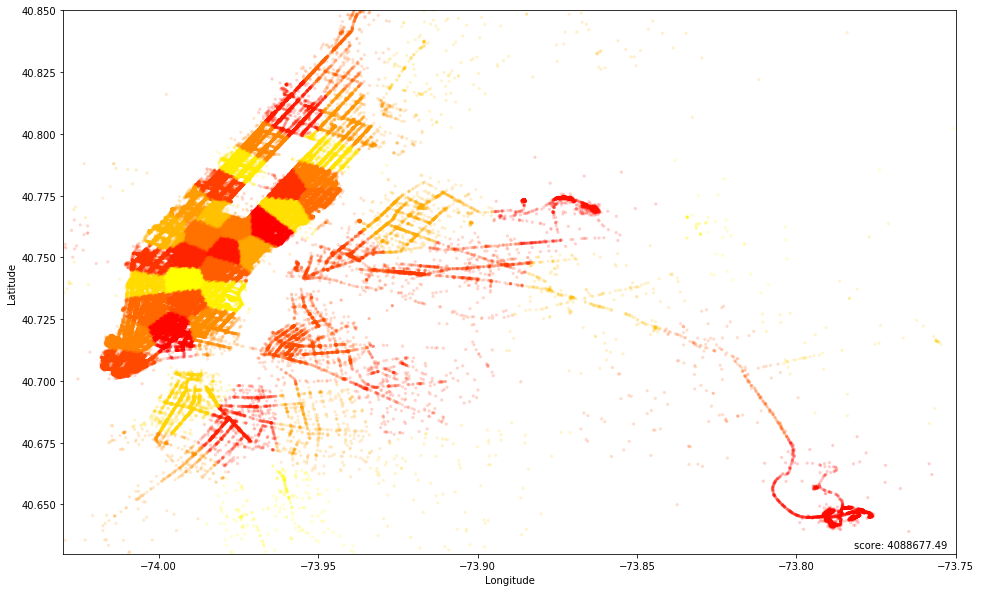

In [6]:
#进行Minibatch Kmeans聚类,cluster=50
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

In [18]:
#进行Minibatch Kmeans聚类,cluster=100
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#输出质心矩阵
print(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])

[ 40.76364187  40.64492895  40.7336476   40.77379518  40.78815772
  40.71525804  40.74332768  40.68296826  40.75784403  40.77654168
  40.74117267  40.71941048  40.78682191  40.71438863  40.64340555
  40.82840416  40.76200196  40.6835971   40.73672016  40.74160947
  40.75059948  40.79592444  40.74900223  40.80809511  40.75708136
  40.84036519  40.77343859  40.79361868  40.6805522   40.72042002
  40.76841285  40.68095005  40.73188822  40.76288894  40.74353874
  40.75716031  40.70764549  40.76940491  40.75029556  40.7358      40.72295098
  40.77626327  40.70390562  40.75316964  40.74886414  40.75585321
  40.8338636   40.64364406  40.70181799  40.74080967  40.72010689
  40.74814476  40.74412359  40.77620707  40.76445166  40.77274673
  40.8230463   40.66612847  40.72724085  40.76169282  40.76796425
  40.78109368  40.8021348   40.75629139  40.70575421  40.67857567
  40.72720222  40.64981264  40.7613252   40.76473567  40.64564997
  40.78738433  40.80762816  40.76513192  40.66122105  40.701613

AttributeError: 'MiniBatchKMeans' object has no attribute 'cluser_centers_'

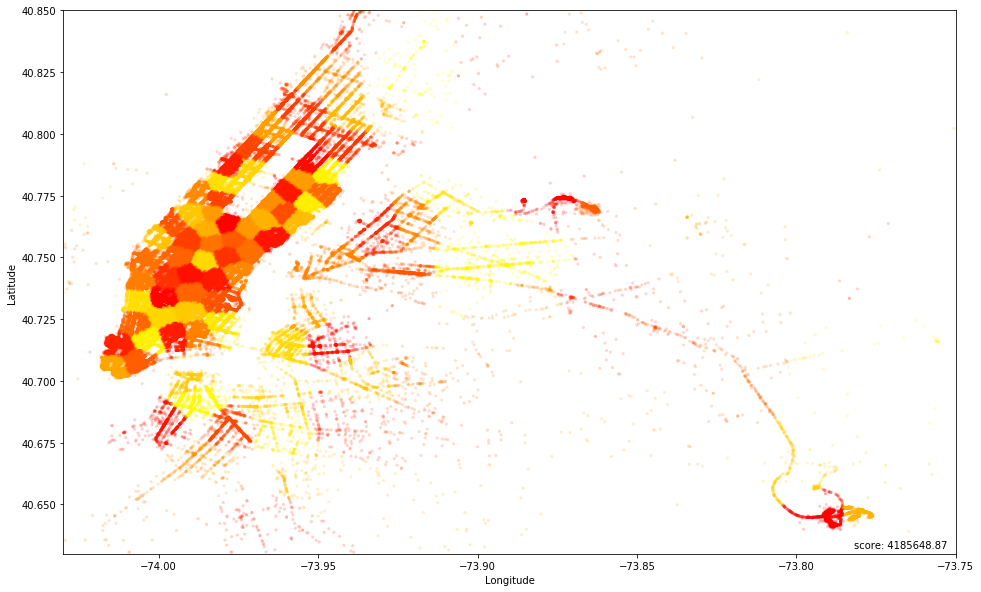

In [20]:
#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

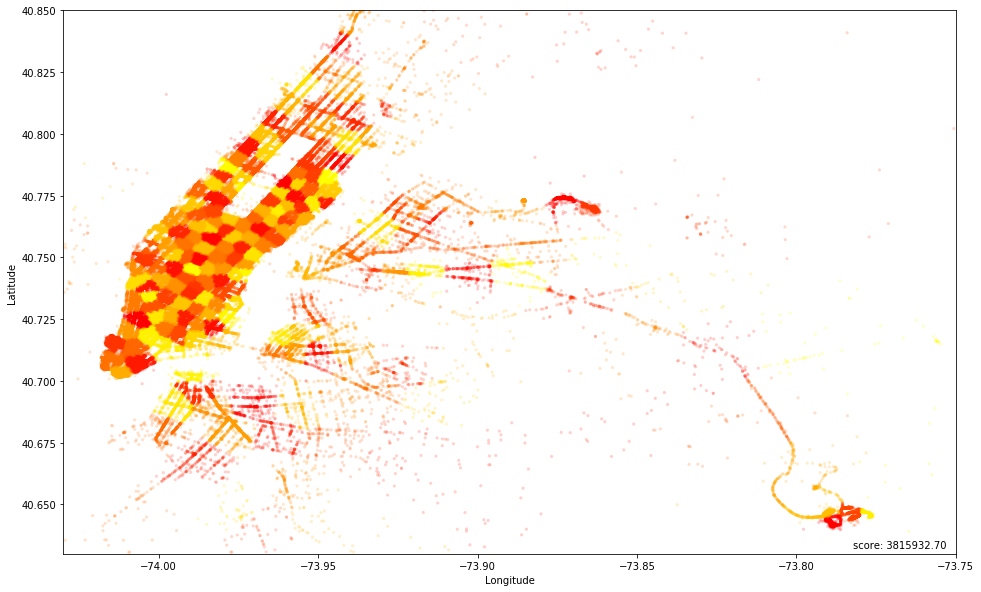

In [19]:
#进行Minibatch Kmeans聚类,cluster=200
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=200, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

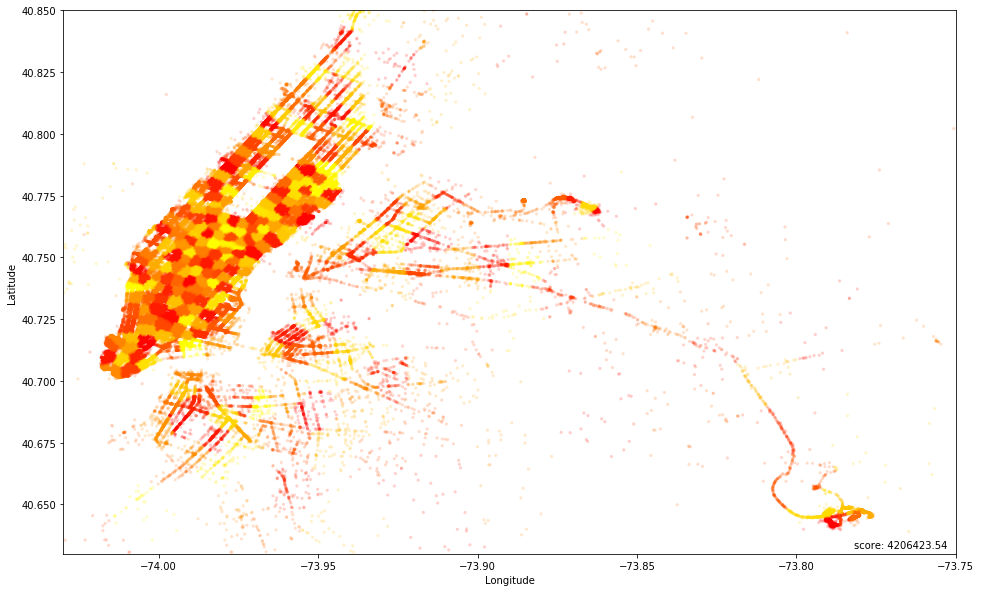

In [20]:
#进行Minibatch Kmeans聚类,cluster=300
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=300, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

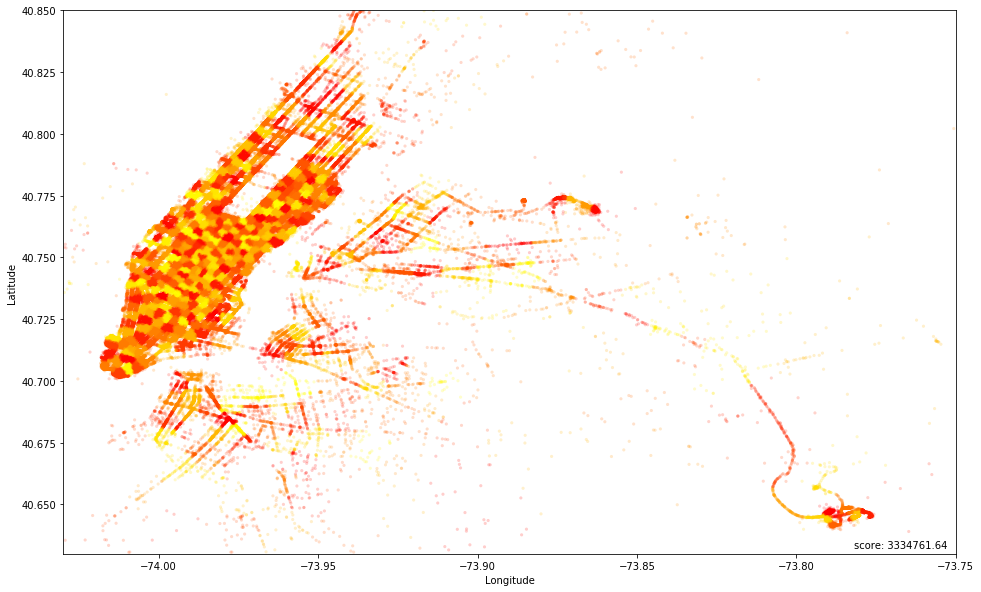

In [21]:
#进行Minibatch Kmeans聚类,cluster=500
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

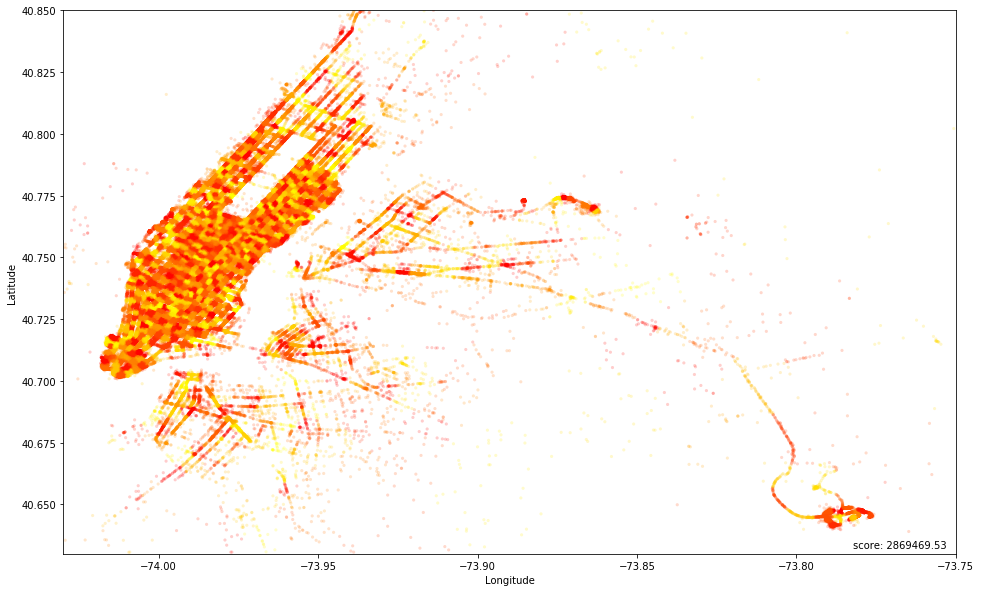

In [22]:
#进行Minibatch Kmeans聚类,cluster=1000
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=1000, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

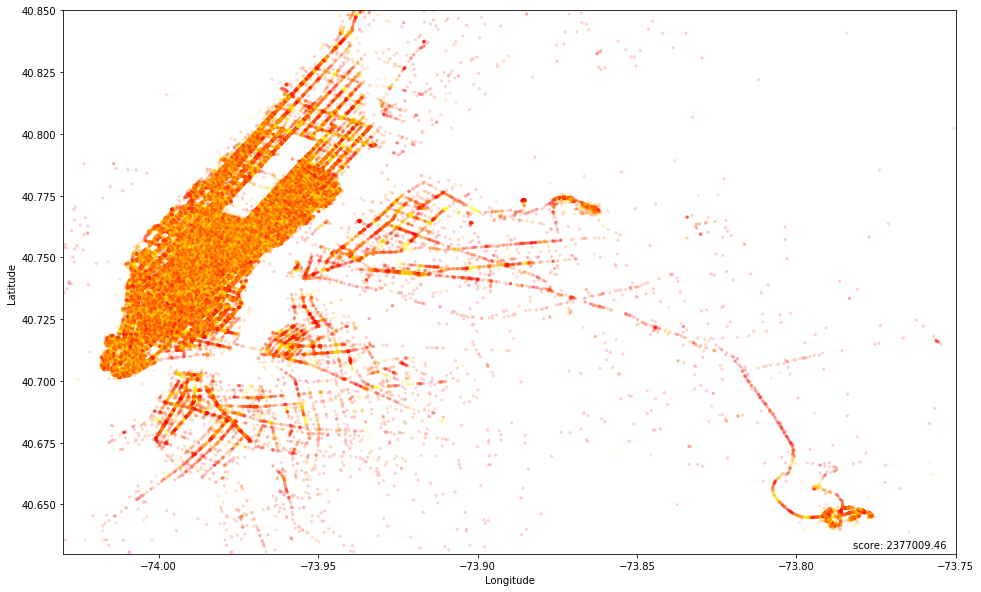

In [24]:
#进行Minibatch Kmeans聚类,cluster=10000
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10000, batch_size=10000).fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

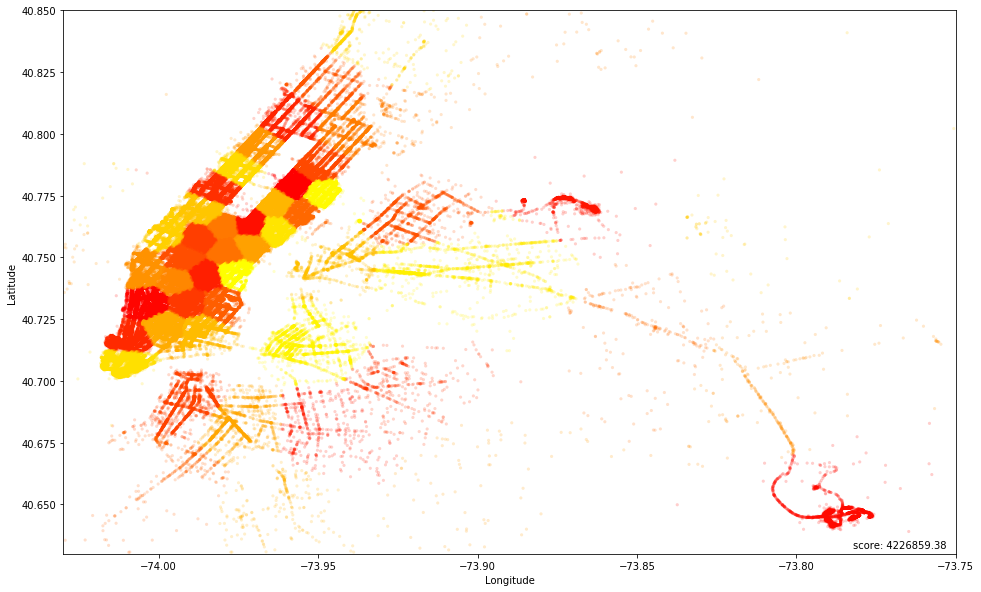

In [28]:
#进行Kmeans聚类,cluster=100
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
kmeans = KMeans(n_clusters=50).fit(coords)
#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

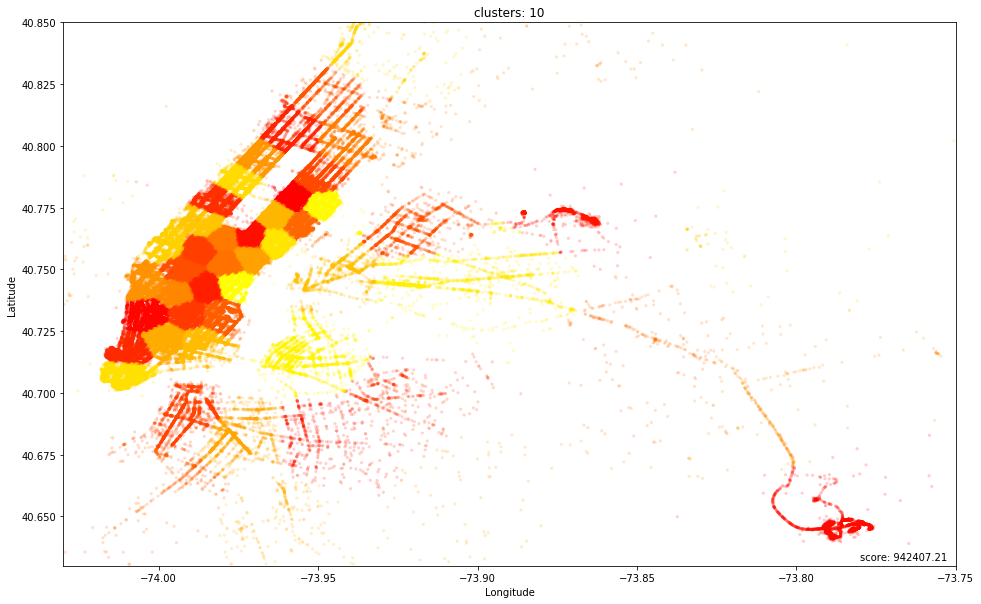

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth
#进行MeanShift聚类
#创建位置堆
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
#配置MeanShift聚类参数
bandwidth = estimate_bandwidth(coords, quantile=0.2,n_samples=500)
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(coords)

#创建实际的聚类
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#对聚类效果进行评估
labels = meanshift.labels_
cluster_centers=meanshift.cluster_centers_
labels_unique=np.unique(labels)
n_clusters_ = len(labels_unique)
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
         horizontalalignment = 'right')
#显示聚类数目
plt.title('clusters: %d' % n_clusters_)
plt.show()

In [ ]:
#对日期的月份信息进行提取
train.info()
#train['Month'] = train['pickup_datetime'].dt.month
#test['Month'] = test['pickup_datetime'].dt.month
#train.groupby('Month').size(),test.groupby('Month').size()

In [ ]:
#进行Minibatch Kmeans聚类,cluster=100，month=1
#创建位置堆
train_month1 = train[train['Month'] == 1]
test_month1 = test[test['Month'] == 1]
coords = np.vstack((train_month1[['pickup_latitude', 'pickup_longitude']].values,
                    train_month1[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)
#创建实际的聚类
train_month1.loc[:, 'pickup_cluster'] = kmeans.predict(train_month1[['pickup_latitude', 'pickup_longitude']])
#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train_month1.pickup_longitude.values[:500000], train_month1.pickup_latitude.values[:500000], s=10, lw=0,
           c=train_month1.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

In [ ]:
#进行Minibatch Kmeans聚类,cluster=100，month=2
#创建位置堆
train_month2 = train[train['Month'] == 2]
test_month2 = test[test['Month'] == 2]
coords = np.vstack((train_month2[['pickup_latitude', 'pickup_longitude']].values,
                    train_month2[['dropoff_latitude', 'dropoff_longitude']].values))
#配置KMeans聚类参数
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)
#配置KMeans聚类参数
train_month2.loc[:, 'pickup_cluster'] = kmeans.predict(train_month2[['pickup_latitude', 'pickup_longitude']])
#显示上车位置的聚类
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train_month2.pickup_longitude.values[:500000], train_month2.pickup_latitude.values[:500000], s=10, lw=0,
           c=train_month2.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#对聚类效果进行评估
labels = kmeans.labels_
score = metrics.calinski_harabaz_score(coords,labels)
plt.text(0.99,.01, ('score: %.2f' % score),
        transform = plt.gca().transAxes, size=10,
        horizontalalignment = 'right')
plt.show()

In [ ]:
#对日期的天数信息进行提取
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

In [ ]:
#对日期的小时信息进行提取
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

In [ ]:
#对日期的星期信息进行提取
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())